# PyTASER DFT Example

In the following examples, we use the outputs from a DFT calculation, using VASP, to generate the predicted absorption spectra under various conditions. Specifically, this requires the calculation of the orbital derivatives between electronic bands, which can be achieved using the `LOPTICS` `INCAR` tag in `VASP` (see (https://www.vasp.at/wiki/index.php/LOPTICS).

**Note:**
In order for VASP to output the necessary information for `PyTASER` to compute the full absorption spectrum under various excitation conditions, the following tags must be set in the `INCAR` file:
```
LOPTICS = True  # calculate the frequency dependent dielectric matrix
LVEL = True  # output the full interband orbital derivative information to the WAVEDER
ISYM = 0  # turn off symmetry, currently required for parsing the WAVEDER with pymatgen
```

We note that alternatively, if only a single-point electronic structure calculation has been performed with VASP (i.e. with no `WAVEDER` output), we can still plot the JDOS of the material in the dark, under illumination, and the difference between them, as shown later.

## Parse DFT Outputs

In [3]:
from pytaser.generator import TASGenerator

In [10]:
tg = TASGenerator.from_vasp_outputs("CdTe/k888_Optics/vasprun.xml", "CdTe/k888_Optics/WAVEDER")

In [13]:
tas = tg.generate_tas(energy_min=0, energy_max=7, temp=300, conc=1e21, cshift=1e-3)
# Note that we set cshift to a small value to avoid too much broadening of the spectrum
# If not set, this defaults to the value of `CSHIFT` used in the underlying VASP
# calculation (see docstrings for more info)

Calculating oscillator strengths (spin up, dark): 100%|██████████| 3900/3900 [00:00<00:00, 25105.38it/s]
Calculating oscillator strengths (spin up, under illumination): 100%|██████████| 3928/3928 [00:00<00:00, 24582.59it/s]


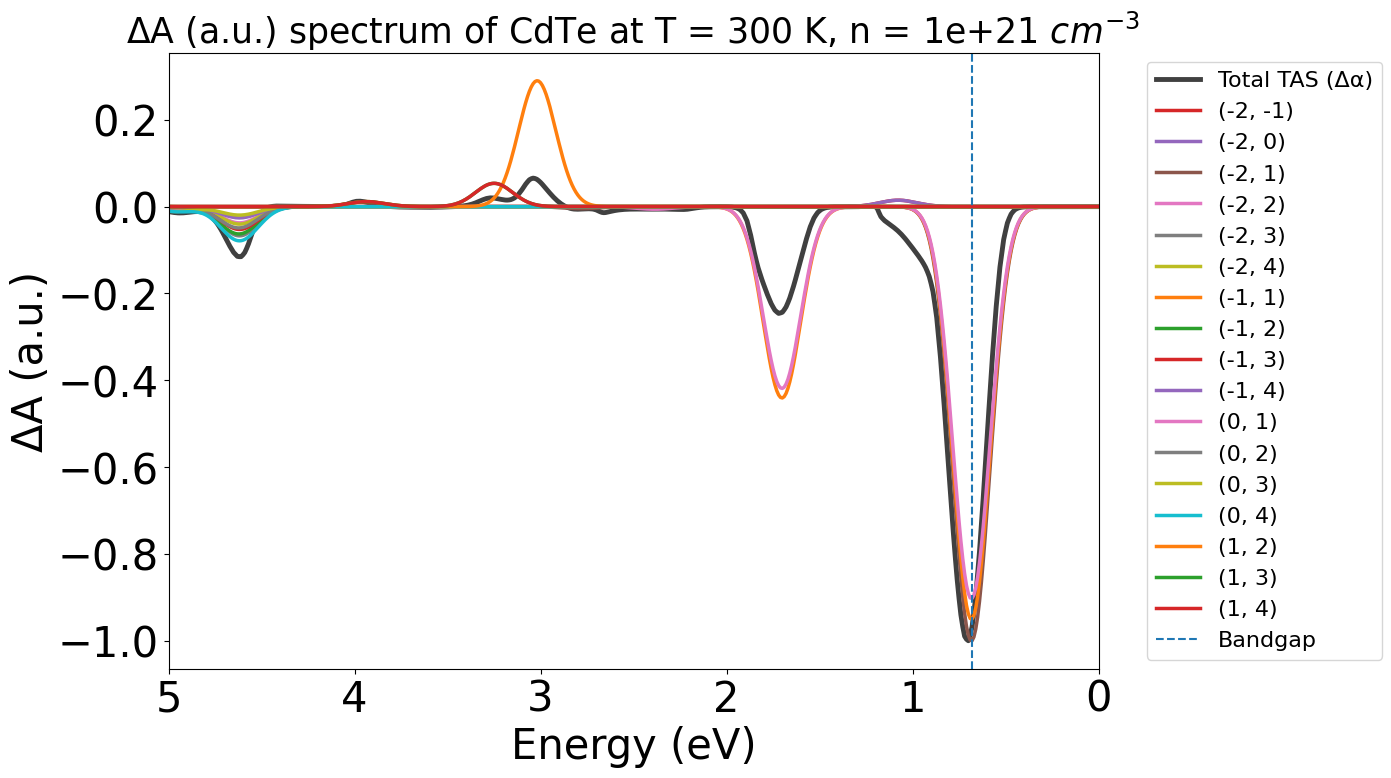

In [14]:
from pytaser.plotter import TASPlotter

plot_dft = TASPlotter(tas, material_name="CdTe")
energy_plot = plot_dft.get_plot(
    xaxis="energy", transition_cutoff=0.01, xmin=0, xmax=5, yaxis="tas")
# Reverse axis for better comparison to experiment
energy_plot.gca().invert_xaxis()

Here our VASP data is from a GGA PBE calculation, which is well-known to underestimate the experimental bandgap. As with the `Materials Project` data workflow in the other tutorial, we can apply a scissor operation to rigidly shift our electronic bands to match the experimental bandgap, like this:

In [15]:
shifted_tg = TASGenerator.from_vasp_outputs(
    "CdTe/k888_Optics/vasprun.xml", "CdTe/k888_Optics/WAVEDER", bg=1.5  # CdTe room temp gap
)

In [16]:
shifted_tas = shifted_tg.generate_tas(energy_min=0, energy_max=7, temp=300, conc=1e22, cshift=1e-3)

Calculating oscillator strengths (spin up, dark): 100%|██████████| 3120/3120 [00:00<00:00, 24882.36it/s]
Calculating oscillator strengths (spin up, under illumination): 100%|██████████| 3145/3145 [00:00<00:00, 24759.86it/s]


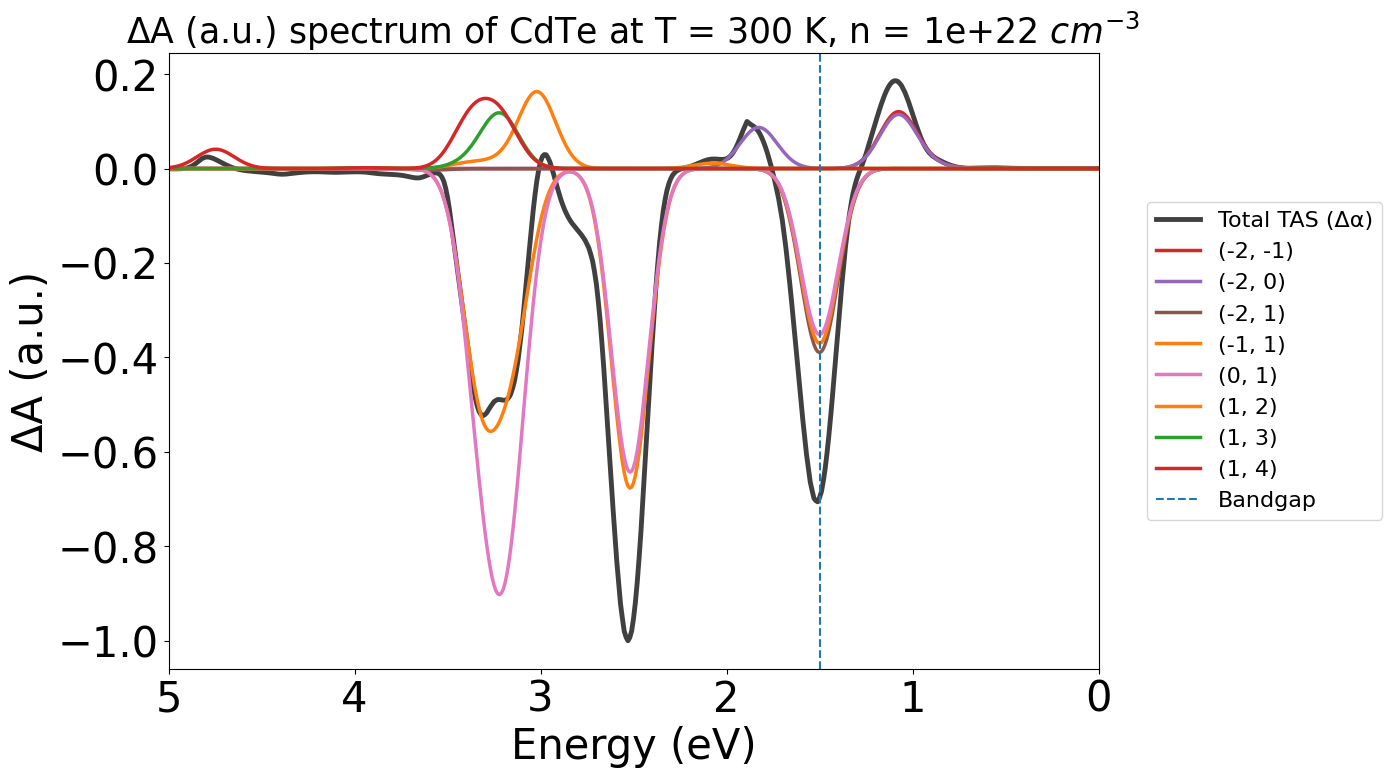

In [17]:
plot_dft = TASPlotter(shifted_tas, material_name="CdTe")
energy_plot = plot_dft.get_plot(
    xaxis="energy", transition_cutoff=0.01, xmin=0, xmax=5, yaxis="tas")
# Reverse axis for better comparison to experiment
energy_plot.gca().invert_xaxis()

Here we can see our ground state bleach (GSB) peak has shifted to the bandgap value of 1.5 eV that we set.

## Plotting

In this example case, our kpoints are not fully converged to give a smooth spectrum (due to the small high-symmetry unit cell of CdTe requiring dense kpoints for a smooth optical spectrum), and so ideally for comparing to experiment we would want a denser kpoint mesh!

We can also plot the predicted TAS as a function of wavelength, by setting `xaxis="wavelength"`:

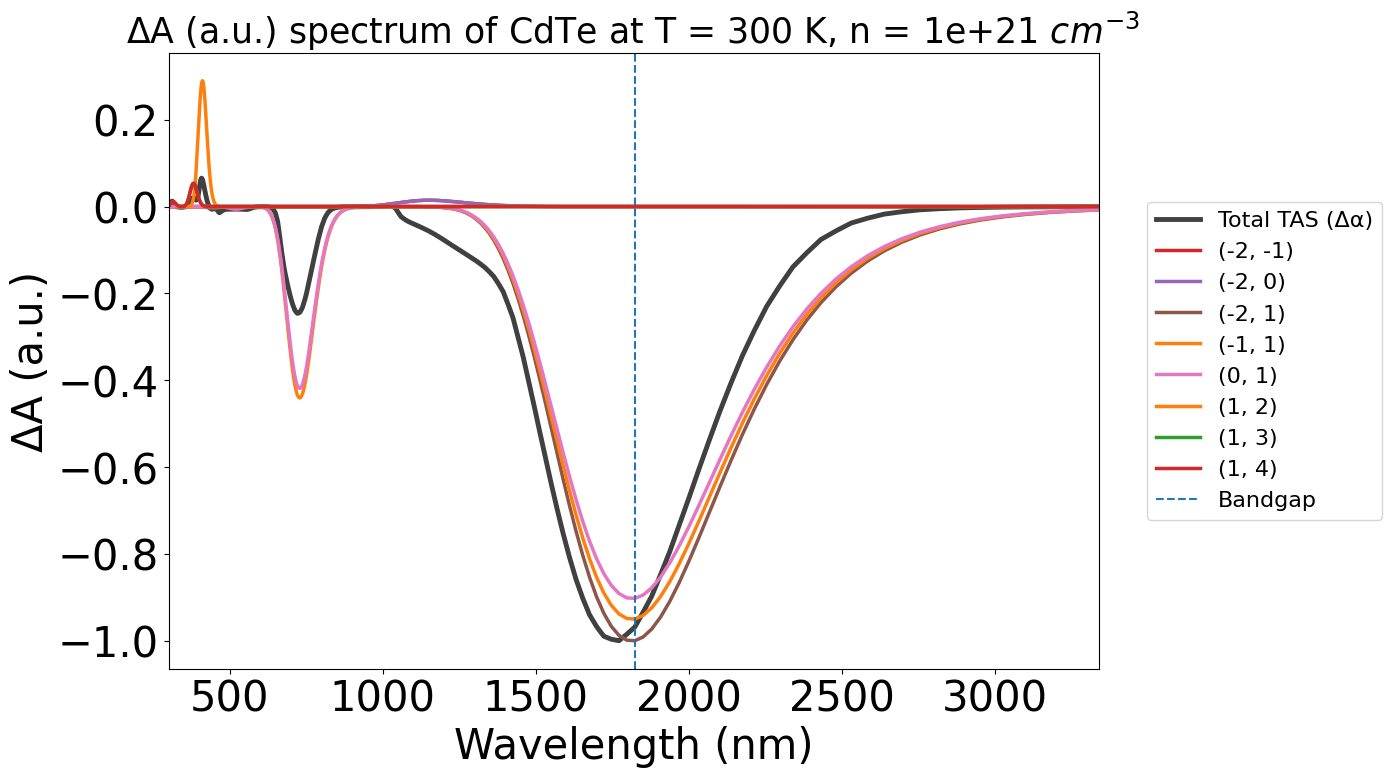

In [18]:
from pytaser.plotter import TASPlotter

plot_dft = TASPlotter(tas, material_name="CdTe")
energy_plot = plot_dft.get_plot(
    xaxis="wavelength", transition_cutoff=0.01, xmin=300, yaxis="tas")

### Plotting the Effective Absorption

We can also plot the predicted effective absorption in the dark and under illumination, by setting `yaxis="alpha"`:

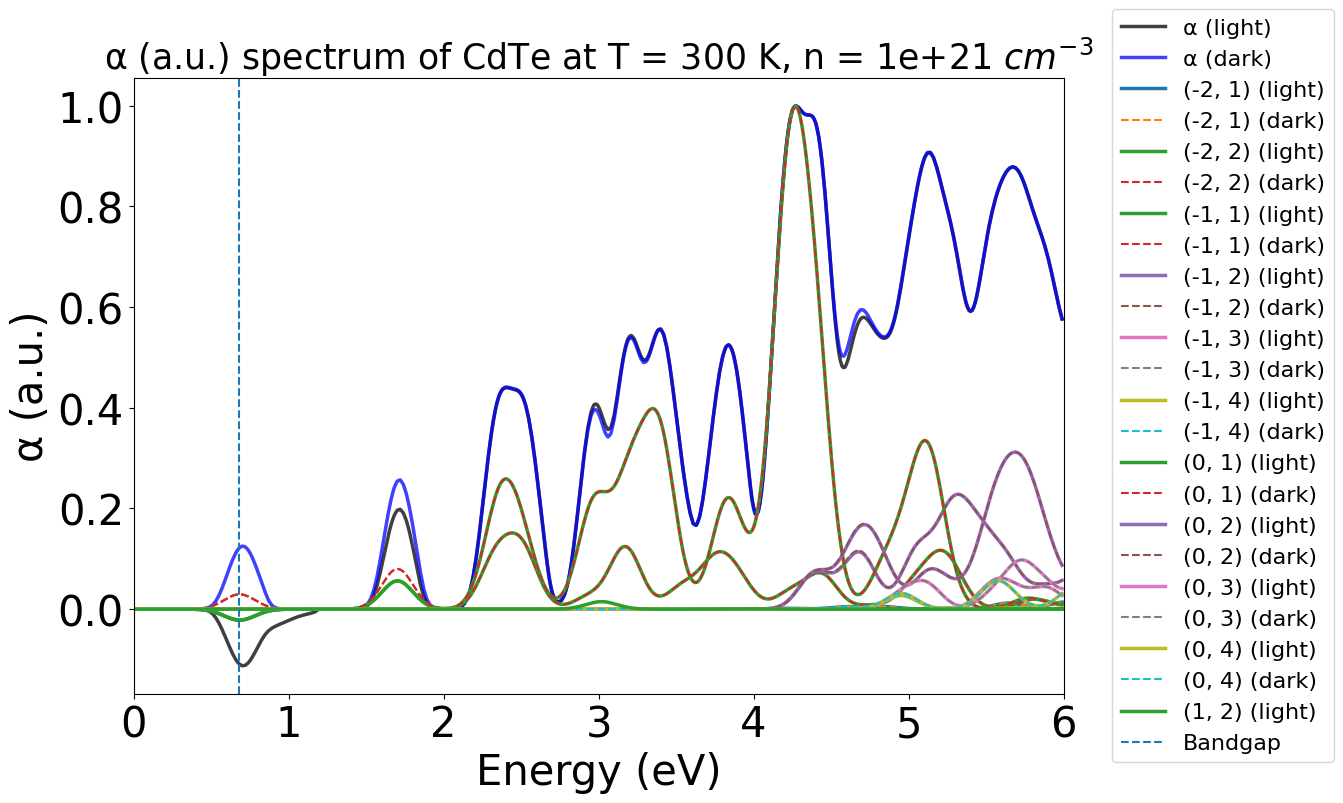

In [20]:
from pytaser.plotter import TASPlotter

plot_dft = TASPlotter(tas, material_name="CdTe")
energy_plot = plot_dft.get_plot(
    xaxis="energy", xmin=0, xmax=6, transition_cutoff=0.01, yaxis="alpha")

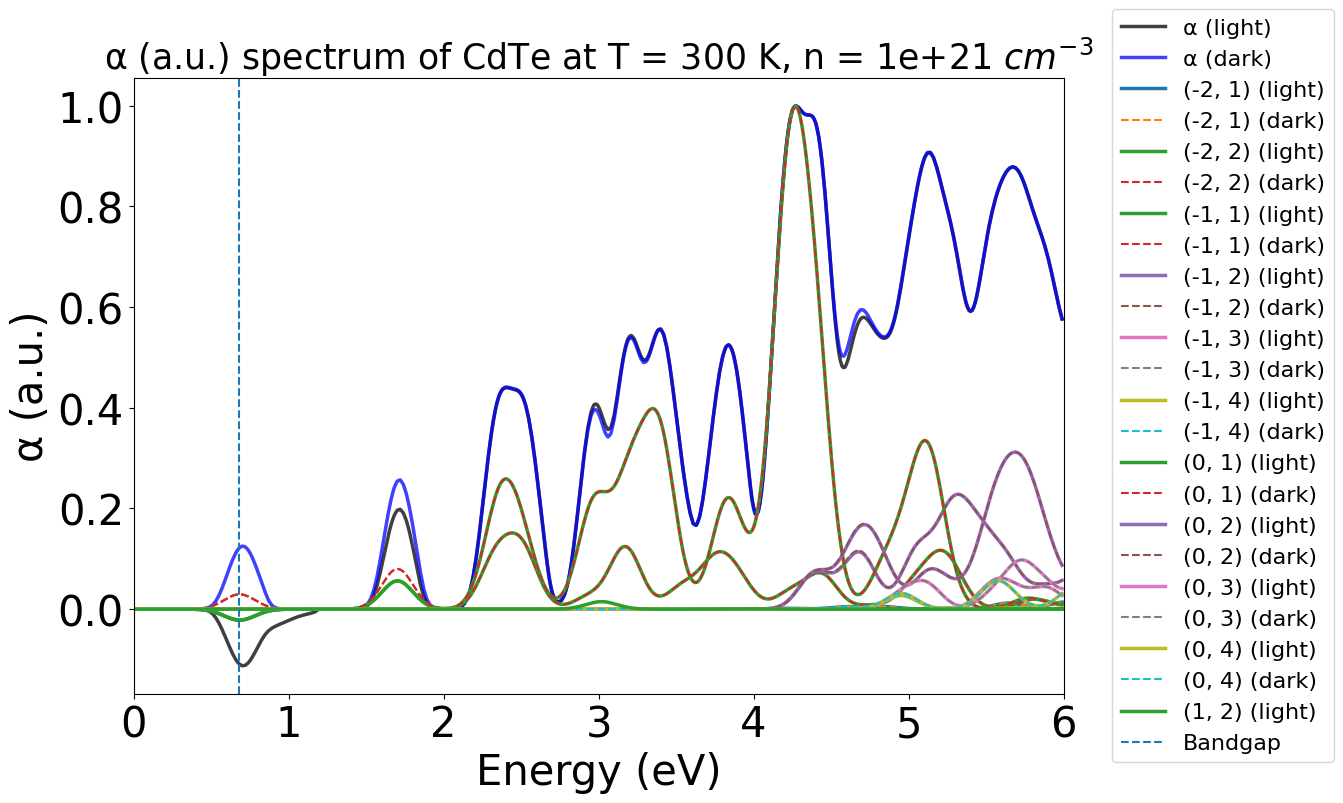

In [21]:
from pytaser.plotter import TASPlotter

plot_dft = TASPlotter(tas, material_name="CdTe")
energy_plot = plot_dft.get_plot(
    xaxis="energy", xmin=0, xmax=6, transition_cutoff=0.01, yaxis="alpha")

We can see that under these conditions, we expect stimulated emission to occur at our bandgap energy (around 0.7 eV here), as we have population inversion at our VBM/CBM, with `ɑ (light)` being negative at this energy

### Plotting the Joint Density of States (JDOS)

Some other plotting options include the ability to plot the JDOS (in the dark and under illumination) with `yaxis="jdos"`, or the difference in JDOS between the dark and illuminated state with `yaxis="jdos_diff"`:

**Note:**
Additional keyword arguments provided to `get_plot()` are passed to `plt.legend()`, so you can use this to customise the plot legend as shown below (see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)

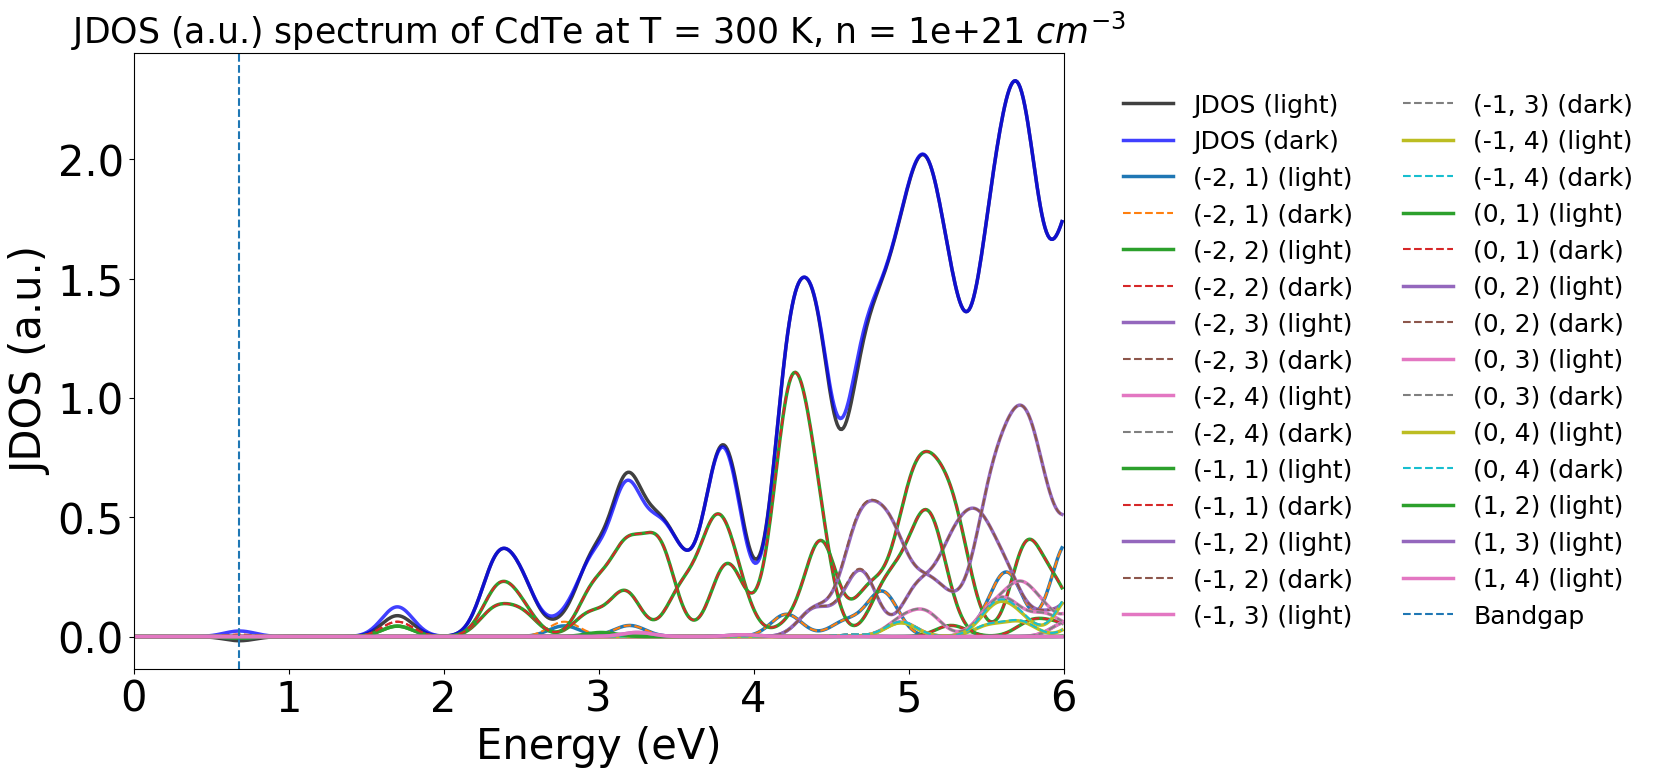

In [23]:
from pytaser.plotter import TASPlotter

plot_dft = TASPlotter(tas, material_name="CdTe")
energy_plot = plot_dft.get_plot(
    xaxis="energy", transition_cutoff=0.01, yaxis="jdos", ncols=2, fontsize=18, frameon=False,
    xmin=0, xmax=6)

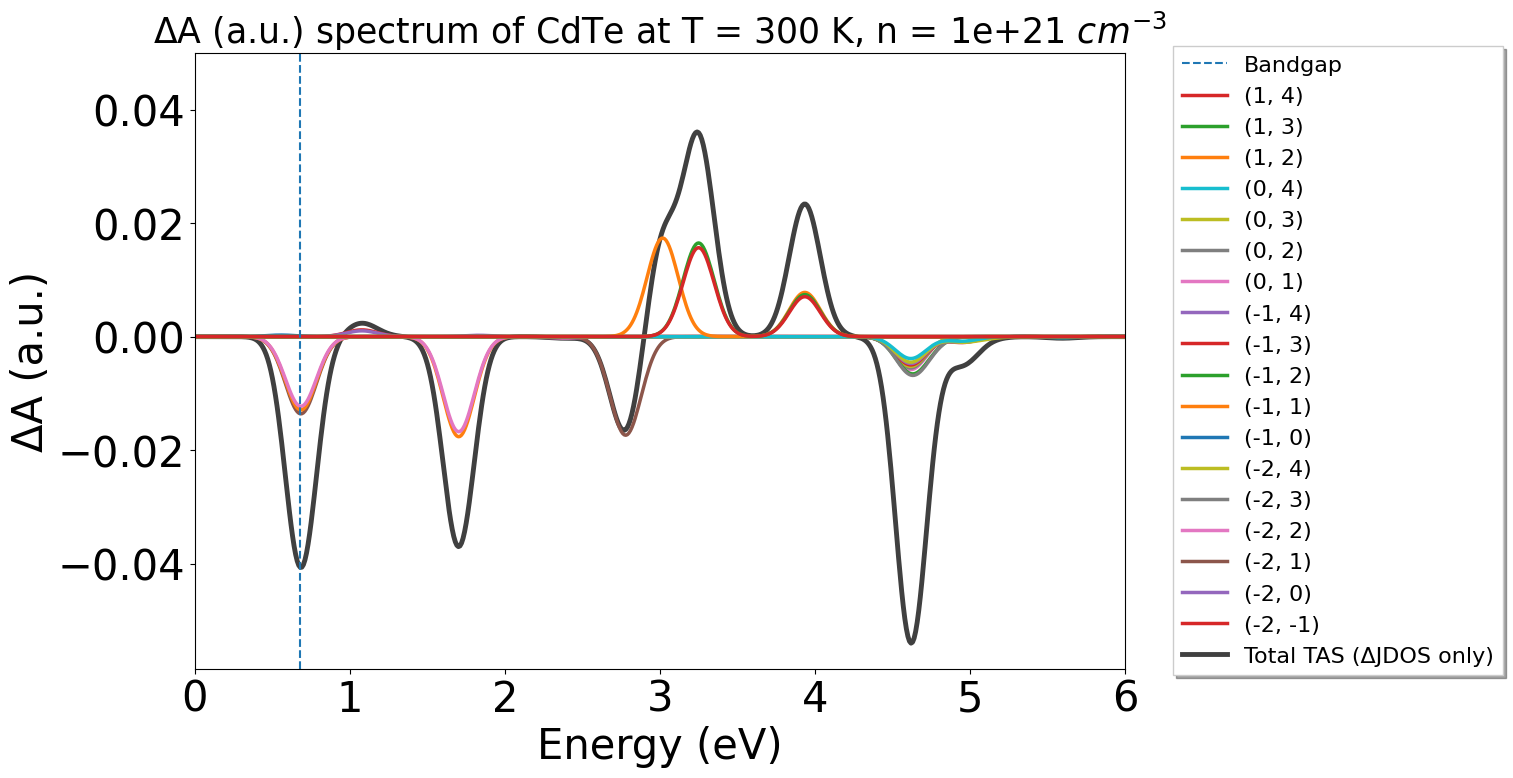

In [25]:
from pytaser.plotter import TASPlotter

plot_dft = TASPlotter(tas, material_name="CdTe")
energy_plot = plot_dft.get_plot(
    xaxis="energy", transition_cutoff=0.01, yaxis="jdos_diff", reverse=True, fancybox=False,
    shadow=True, xmin=0, xmax=6, ymax=0.05)

## MAPI (CH$_3$NH$_3$PbI$_3$), 6x6x6 kpoint mesh, with spin-orbit coupling (SOC)

Let's look at another example; the cubic perovskite MAPI (CH$_3$NH$_3$PbI$_3$), with a 6x6x6
kpoint mesh, and with spin-orbit coupling (SOC) included in the calculation. The dense k-point mesh along with low symmetry (due to the organic molecule) and increase in bands due to SOC, means that this is a more expensive case to calculate.

In [26]:
tg = TASGenerator.from_vasp_outputs("MAPI/vasprun.xml.gz", "MAPI/WAVEDER")

In [27]:
import time  # for timing the parsing
start = time.time()
tas = tg.generate_tas(temp=300, conc=1e22, cshift=1e-3)
print(f"Elapsed time: {time.time() - start:.2f} s")

Calculating oscillator strengths (spin up, dark): 100%|██████████| 85536/85536 [00:03<00:00, 23455.02it/s]
Calculating oscillator strengths (spin up, under illumination): 100%|██████████| 88718/88718 [00:03<00:00, 24890.09it/s]


Elapsed time: 303.11 s


Here we see that the parsing of the VASP outputs can take ~300 seconds (5 minutes) to run, so it's a good idea to save the parsed data to a `json` file, so that we don't have to re-parse the data every time we want to re-run our analysis. We can do this using the `monty.serialization` functions (installed by default with `pymatgen`) as shown below:

In [28]:
from monty.serialization import dumpfn
dumpfn(tas, "MAPI_tas.json")

When we want to redo some of this analysis, in this notebook or a new one, we can now load the TAS object from the `json` file without having to re-parse the `WAVEDER` data, like this:

In [29]:
from monty.serialization import loadfn
tas = loadfn("MAPI_tas.json")

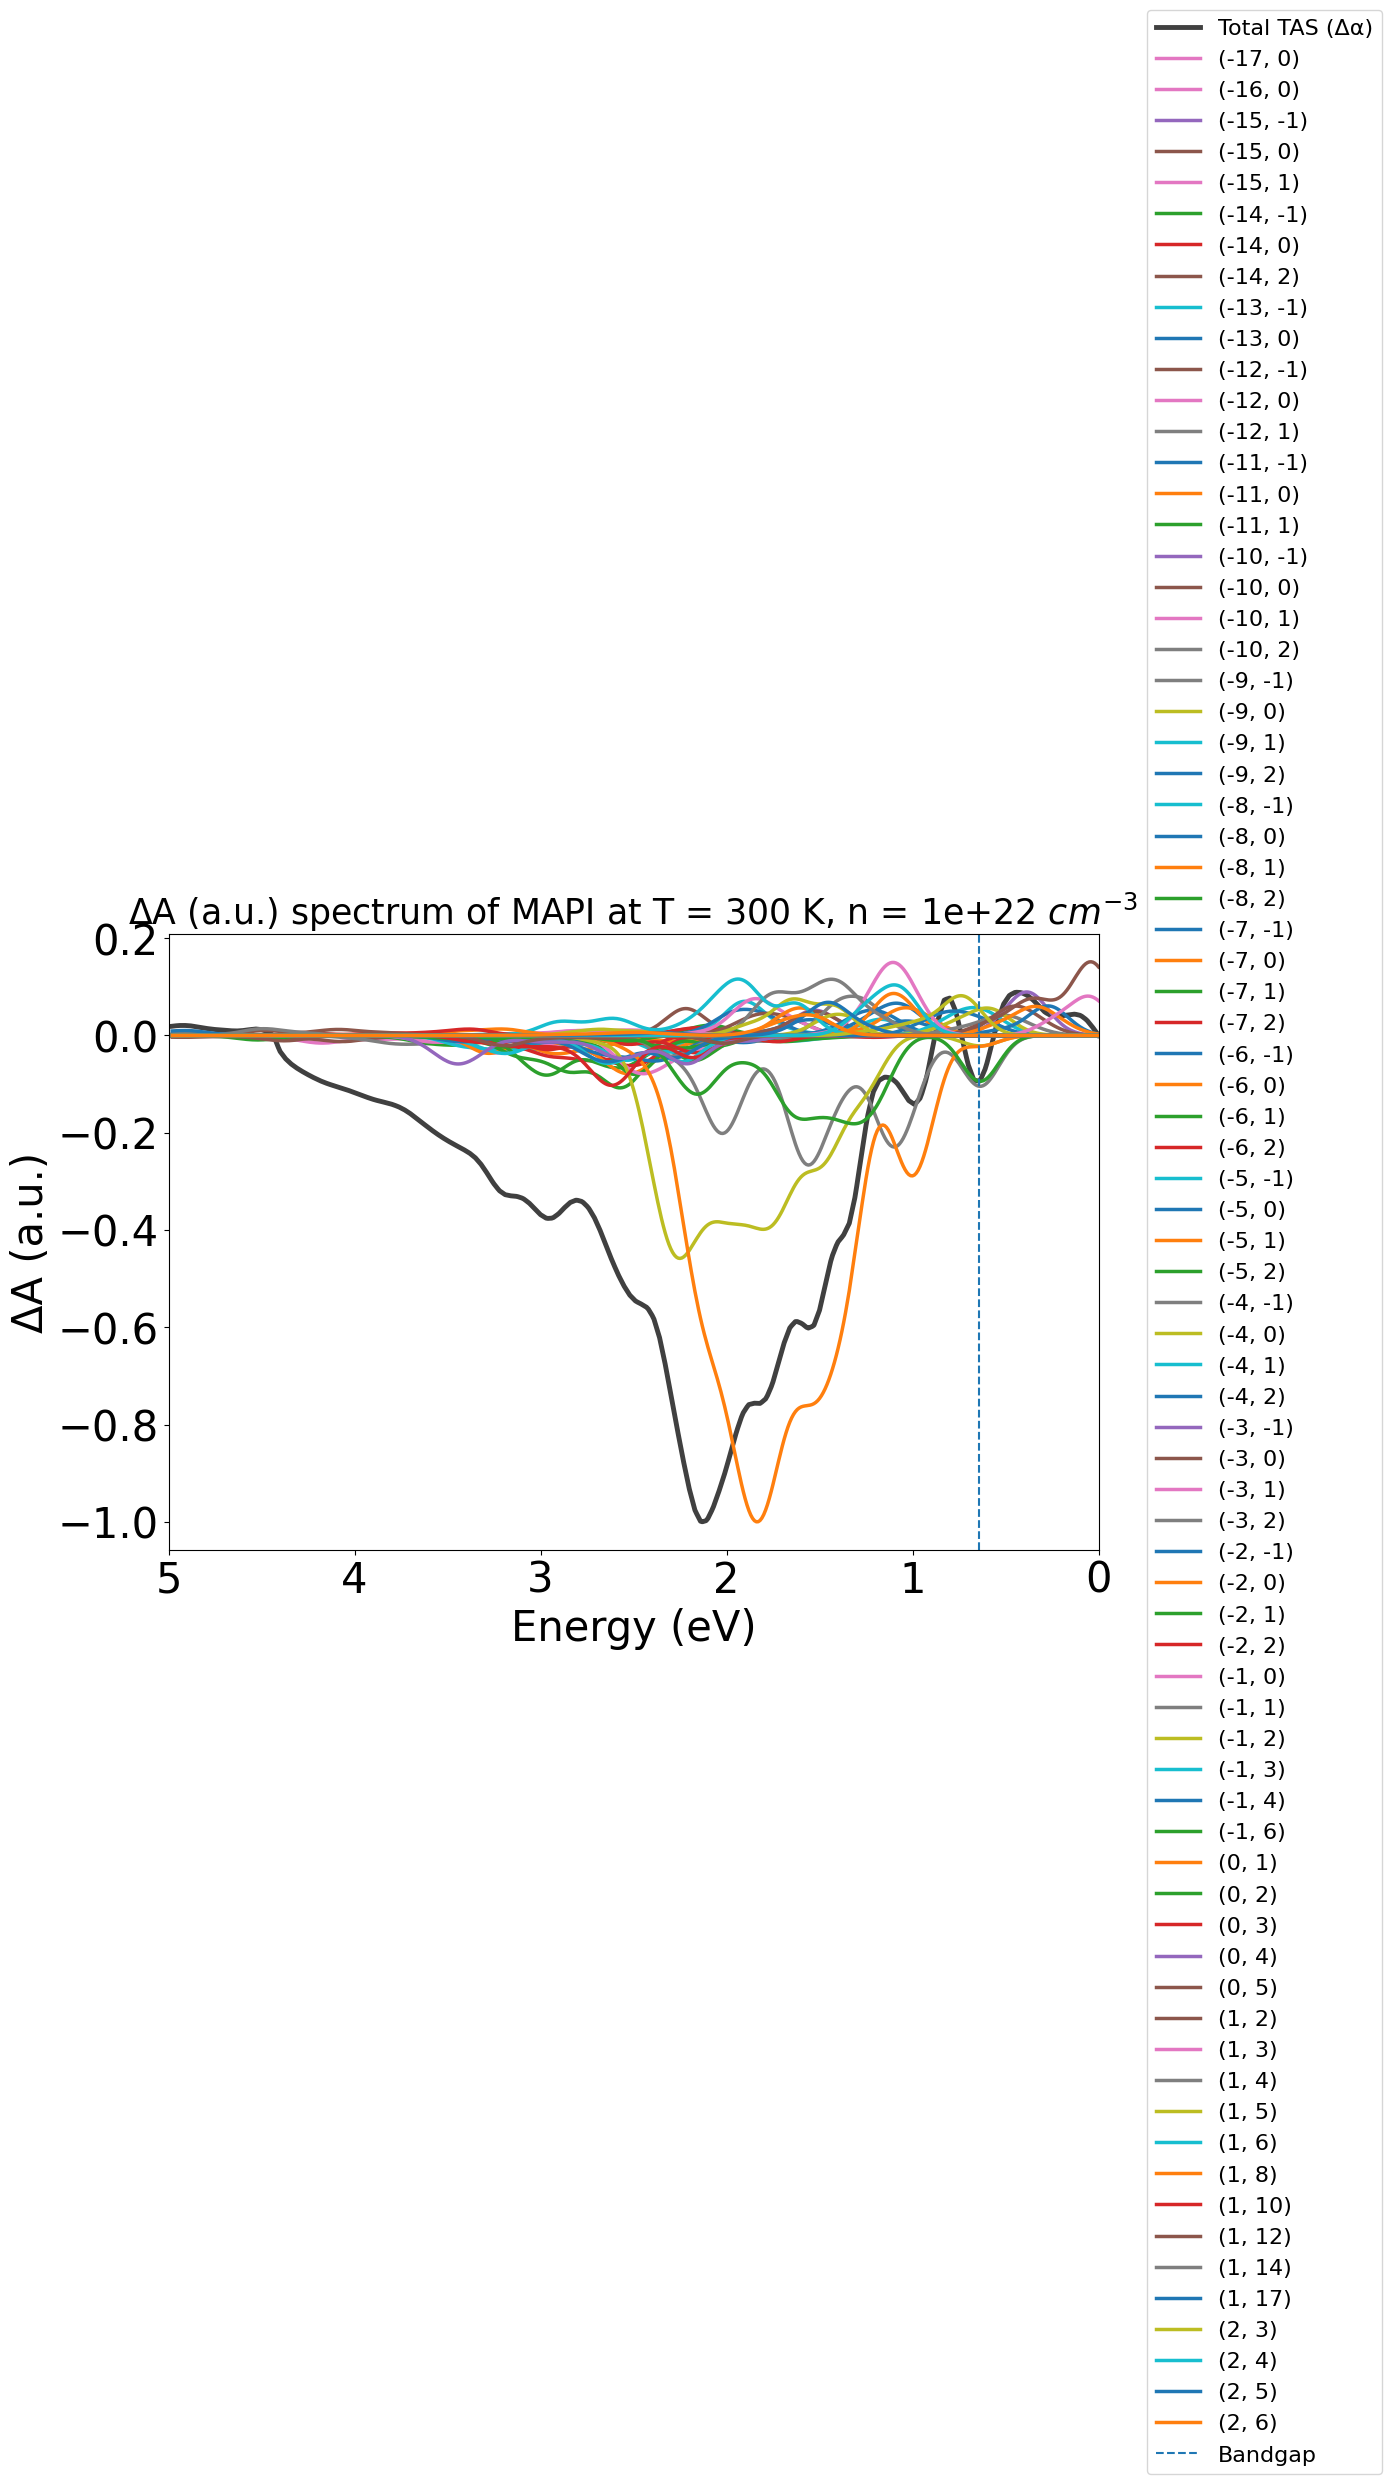

In [30]:
# plot the result:
plot_dft = TASPlotter(tas, material_name="MAPI")
energy_plot = plot_dft.get_plot(
    xaxis="energy", transition_cutoff=0.01, xmin=0, xmax=5, yaxis="tas")
# Reverse axis for better comparison to experiment
energy_plot.gca().invert_xaxis()

Here due to the low symmetry of the _static_ perovskite structure and SOC splitting of the electronic bands, we end up with many contributing band-band transitions at low energies. We can reduce the plot legend to only name the strongest contributing transitions by adjusting `transition_cutoff`, and also setting `ncols` to 2 to make the legend easier to read:

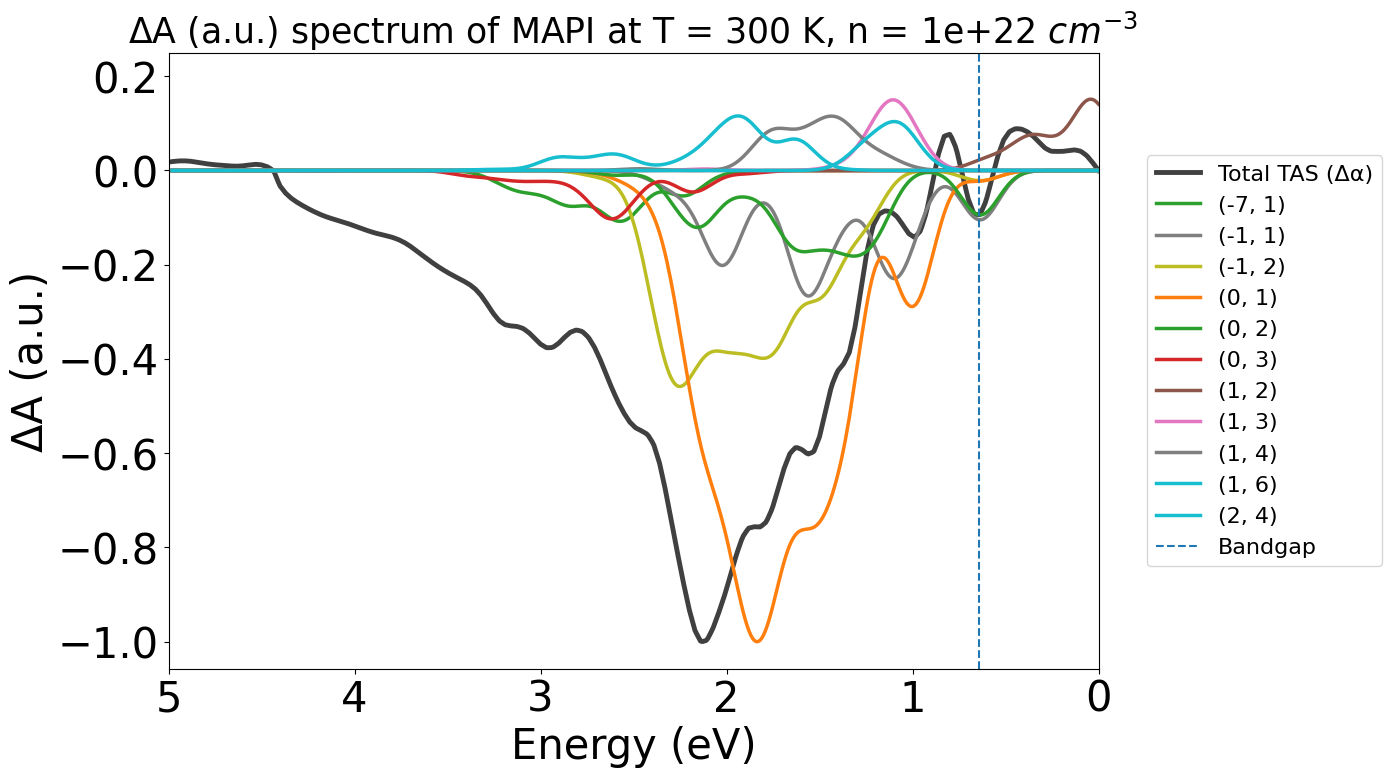

In [36]:
# plot the result:
plot_dft = TASPlotter(tas, material_name="MAPI")
energy_plot = plot_dft.get_plot(
    xaxis="energy", transition_cutoff=0.1, xmin=0, xmax=5, yaxis="tas", ymax=0.25)
# Reverse axis for better comparison to experiment
energy_plot.gca().invert_xaxis()

Here we can see the dominant contribution is a large ground state bleach for the VBM -> CBM transition (`(0,1)`) in orange.

## Parse DFT Outputs (JDOS Only)

As mentioned above, if we've only performed a single-point electronic structure calculation with VASP, we can still plot the JDOS of the material in the dark, under illumination, and the difference between them, as shown below.

In [9]:
from pytaser.generator import TASGenerator

In [10]:
tg = TASGenerator.from_vasp_outputs("CdTe/k666_Optics/vasprun.xml")  # No WAVEDER file this time

In [11]:
tas = tg.generate_tas(energy_min=0, energy_max=7, temp=300, conc=1e22)

In this case if we set `yaxis = "tas"`, it will use the difference in JDOS between the dark and illuminated state to generate an estimated TAS spectrum:

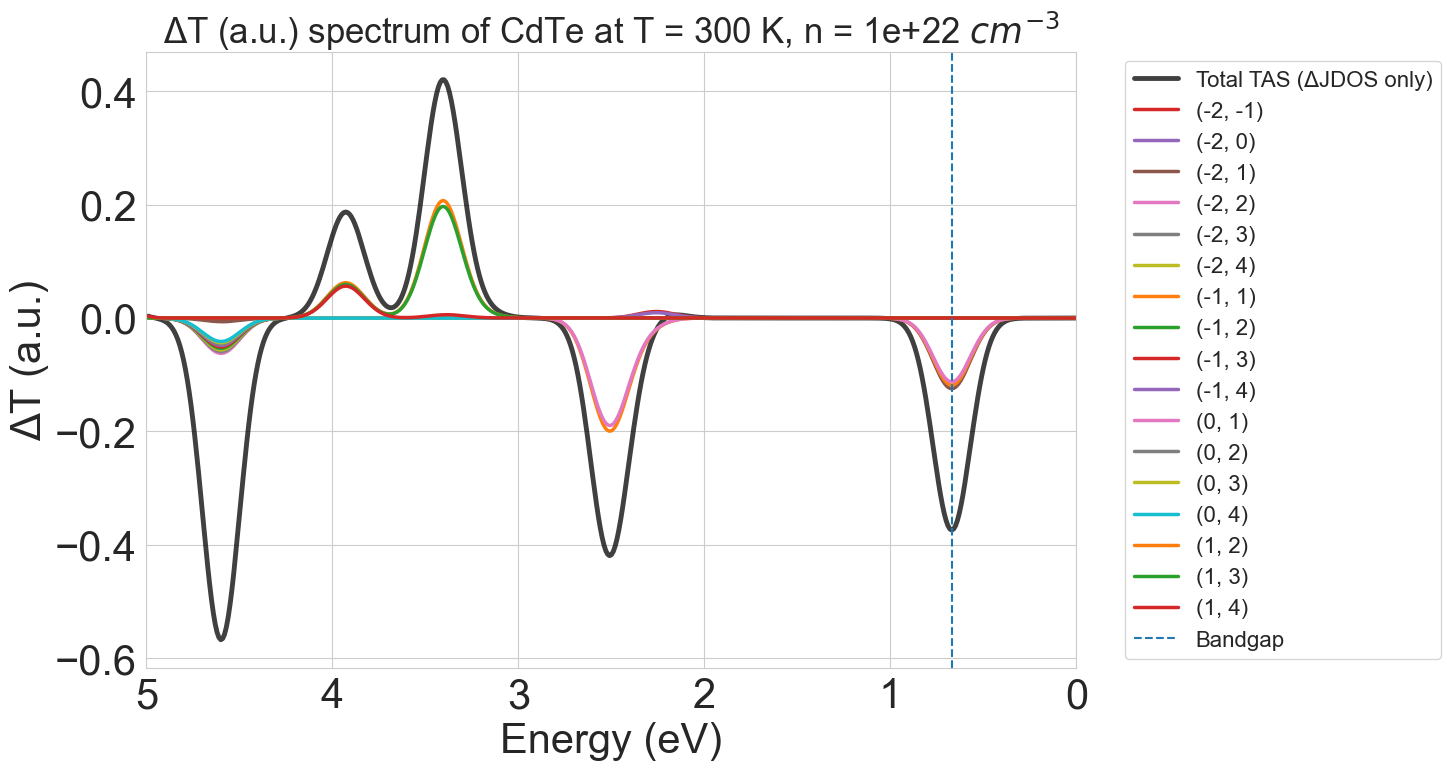

In [33]:
from pytaser.plotter import TASPlotter

plot_dft = TASPlotter(tas, material_name="CdTe")
energy_plot = plot_dft.get_plot(
    xaxis="energy", transition_cutoff=0.01, xmin=0, xmax=5, yaxis="tas")
# Reverse axis for better comparison to experiment
energy_plot.gca().invert_xaxis()

Similarly, we can directly plot the JDOS in the dark and under illumination with `yaxis="jdos"`:

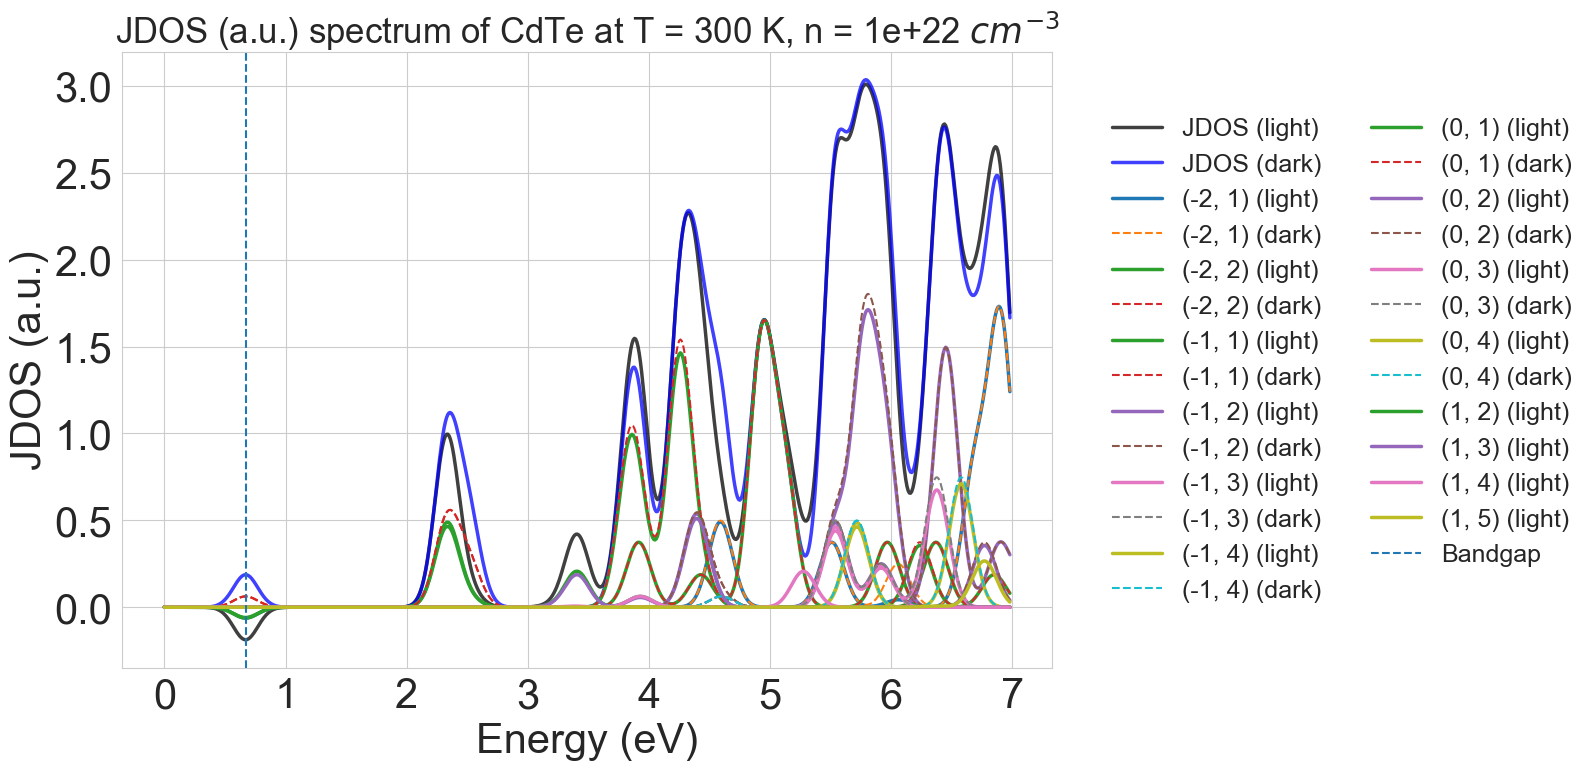

In [34]:
from pytaser.plotter import TASPlotter

plot_dft = TASPlotter(tas, material_name="CdTe")
energy_plot = plot_dft.get_plot(
    xaxis="energy", transition_cutoff=0.01, yaxis="jdos", ncols=2, fontsize=18, frameon=False)